In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from itertools import product
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib
import torch.nn as nn

matplotlib.rcParams['text.usetex'] = True

pretty_pyplot_layout()

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from multiprocessing import Pool

@dataclass
class HyperParams:
    nMic: int
    n_refine: int
    xDim: int
    yDim: int
    width: float
    height: float
    tol: float
    max_iter: int
        
    
    
class Setup():
    def __init__(self, data: StokesData, param: HyperParams, net: nn.Module, net_settings: dict):
        """Create a new HMM setup with the given parameters."""
        self.params = param
        self.data = data
        
        # Macro problem
        macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=data.dom[0]))
        macro_solver = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Micro problems
        self.xPos = np.linspace(data.dom[0][0], data.dom[0][1], param.nMic+1)[1:] - param.width/2 - (data.dom[0][1]-data.dom[0][0]) / param.nMic/1
        micros = [StokesMicProb(data, x, param.width, param.height, 0.0, 8, param.xDim, param.yDim, n_refine=param.n_refine) for x in self.xPos]
        micro_solvers = [MicroSolver(m, tol=param.tol) for m in micros]
        deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, tol=param.tol) for m in micros]
        
        # Convergence checker
        conv_checker = ConvergenceChecker(macro, micros, tol=param.tol)
        
        # HMM problem
        self.hmm_problem = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)
        self.hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
        self.hmm_deep_solver = IterativeHMMSolver(macro_solver, deep_micro_solvers)
        
        
    def solve(self, **kwargs):
        macro_guess = self.hmm_solver.macro_solver.solve(self.hmm_problem.macro)
        (macro_sol, micro_sols) = self.hmm_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        (deep_macro_sol, deep_micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        return micro_sols, macro_sol, deep_micro_sols, deep_macro_sol, macro_guess
    
    
    def save_sol(self, macro_sol, deep_macro_sol, filename):
        data = self.params.__dict__
        data['sol_u'] = macro_sol.u.eval_grid()
        data['sol_v'] = macro_sol.v.eval_grid()
        data['deep_sol_u'] = deep_macro_sol.u.eval_grid()
        data['deep_sol_v'] = deep_macro_sol.v.eval_grid()
        np.save(filename, data)
        
        
    def load_sol(filename):
        data = np.load(filename, allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        u_deep = data.pop('deep_sol_u')
        v_deep = data.pop('deep_sol_v')
        par = HyperParams(**data)
        return par, u, v, u_deep, v_deep

/tmp/ipykernel_26456/3915601397.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


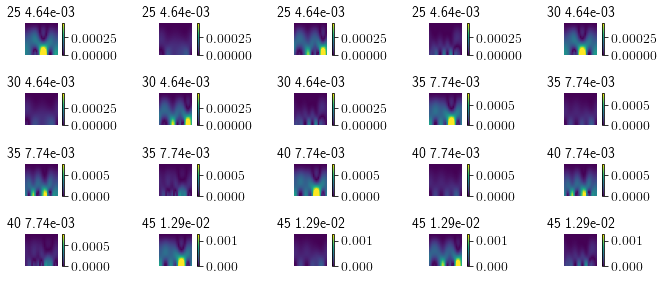

In [2]:
dir = "/home/emastr/phd/data/hmm_sols"
w_list = [4, 5] #[1, 2, 3, 4, 5, 6, 7, 8]
n_list = [7, 11] #[3, 5, 7, 9, 11, 13, 15, 17]
i_list = [25, 30, 35, 40, 45] #list(range(25, 60, 5))


args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]
errs = {'max':[], 'L1':[], 'L2':[], 'deep-max':[], 'deep-L1':[], 'deep-L2':[]}
idx2eps = {}
nroot = int(np.ceil(np.sqrt(len(list(args)))))
for idx, (i, n, w) in enumerate(list(args)):
    par, u, v, u_deep, v_deep = Setup.load_sol(f"/home/emastr/phd/data/hmm_sols/sol_{i}_{n}_{w}.npy")
    data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_2/run_{i}.mat")
    eps = float(info['eps'])
    plt.subplot(nroot, nroot, idx+1)
    plt.title(f"{i} {eps:.2e}")
    plt.imshow(np.abs(u[::-1, ::-1].T - u_deep[::-1, ::-1].T), vmin=0, vmax=eps/10)
    plt.axis('off')
    plt.colorbar()
    # U HMM solution
        

np.save("/home/emastr/phd/data/hmm_sols/sol_table.npy", [args, errs, idx2eps])

In [3]:
dir = "/home/emastr/phd/data/hmm_sols"
w_list = [1, 2, 3, 4, 5, 6, 7, 8]
n_list = [3, 5, 7, 9, 11, 13, 15, 17]
i_list = list(range(25, 60, 1))


args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]
errs = {'max':[], 'L1':[], 'L2':[], 'deep-max':[], 'deep-L1':[], 'deep-L2':[]}
idx2eps = {}
for i, n, w in list(args):
    try:    
        par, u, v, u_deep, v_deep = Setup.load_sol(f"/home/emastr/phd/data/hmm_sols/sol_{i}_{n}_{w}.npy")
        data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_2/run_{i}.mat")
        print(f"{i},{n},{w} loaded", end="\r")
    except:
        print(f"{i},{n},{w} failed", end="\r")
        continue
    # U HMM solution
    coef = BasisProduct._interpolate(u, FourBasis, ChebBasis)
    u_basis = BasisProduct(coef, *coef.shape, FourBasis, ChebBasis)
    scale, shift = ScaleShiftedBasisProduct._domain_to_scale_shift(u_basis.domain(), data.dom)
    u_basis = ScaleShiftedBasisProduct(u_basis, scale, shift)
    
    # U HMM solution
    coef_deep = BasisProduct._interpolate(u_deep, FourBasis, ChebBasis)
    u_basis_deep = BasisProduct(coef_deep, *coef_deep.shape, FourBasis, ChebBasis)
    scale, shift = ScaleShiftedBasisProduct._domain_to_scale_shift(u_basis_deep.domain(), data.dom)
    u_basis_deep = ScaleShiftedBasisProduct(u_basis_deep, scale, shift)
        
    # U true solution
    bbox = info["bbox"]
    Uc = info['Uc']
    eps = float(info['eps'])
    nper= int(info['freq_g'])
    idx2eps[i] = (eps, nper)
    x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
    y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
    u_sol = PiecewiseInterp2D(x, y, Uc)
    
    # Evaluate on strip close to the wall
    y_val_1 = 2*eps*np.log(1/eps)
    y_val_0 = 0.5*eps*np.log(1/eps)
    area = 1#(y_val_1 - y_val_0)*(data.dom[0][1] - data.dom[0][0])
    nx, ny = 100, 20
    Xval, Yval = np.meshgrid(np.linspace(*data.dom[0], nx), np.linspace(y_val_0, y_val_1, ny))
    
    err = np.abs(u_sol(Xval, Yval) - u_basis(Xval.flatten(), Yval.flatten()).reshape(ny, nx))
    errs['max'].append(np.max(err)/eps)
    errs['L1'].append(np.mean(err)*area/eps)
    errs['L2'].append(np.sqrt(np.mean(err**2))*area/eps)
    
    err = np.abs(u_sol(Xval, Yval) - u_basis_deep(Xval.flatten(), Yval.flatten()).reshape(ny, nx))
    errs['deep-max'].append(np.max(err)/eps)
    errs['deep-L1'].append(np.mean(err)*area/eps)
    errs['deep-L2'].append(np.sqrt(np.mean(err**2))*area/eps)
        

np.save("/home/emastr/phd/data/hmm_sols/sol_table.npy", [args, errs, idx2eps])

/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


dict_values([(0.004641588833612777, 3), (0.004641588833612777, 4), (0.004641588833612777, 5), (0.004641588833612777, 6), (0.004641588833612777, 7), (0.004641588833612777, 8), (0.004641588833612777, 9), (0.004641588833612777, 10), (0.007742636826811269, 3), (0.007742636826811269, 4), (0.007742636826811269, 5), (0.007742636826811269, 6), (0.007742636826811269, 7), (0.007742636826811269, 8), (0.007742636826811269, 9), (0.007742636826811269, 10), (0.01291549665014884, 3), (0.01291549665014884, 4), (0.01291549665014884, 5), (0.01291549665014884, 6), (0.01291549665014884, 7), (0.01291549665014884, 8), (0.01291549665014884, 9), (0.01291549665014884, 10), (0.021544346900318832, 3), (0.021544346900318832, 4), (0.021544346900318832, 5), (0.021544346900318832, 6), (0.021544346900318832, 7), (0.021544346900318832, 8), (0.021544346900318832, 9), (0.021544346900318832, 10), (0.03593813663804628, 3), (0.03593813663804628, 4), (0.03593813663804628, 5)])
[0.0800402814057528, 0.06378631092650092, 0.0483

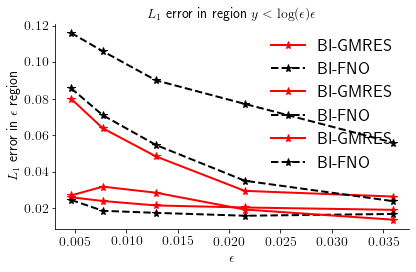

In [6]:
import pandas as pd
i_range = list(range(25, 60, 1))# list(range(25, 60, 1))
#n = int(np.ceil(len(i_range)**0.5))
n_rows = 8
n_cols = 5

grid_search = np.load("/home/emastr/phd/data/hmm_sols/sol_table.npy", allow_pickle=True)
vals = list(zip(*list(grid_search[1].values())))
idx2eps = grid_search[2]
table = pd.DataFrame(vals, index=pd.MultiIndex.from_tuples(grid_search[0], names=['i', 'n', 'w']), columns=list(grid_search[1].keys()))

#w = [4, 5] #[1, 2, 3, 4, 5, 6, 7, 8]
#n = [7, 11] #[3, 5, 7, 9, 11, 13, 15, 17]
#i = [25, 30, 35, 40, 45] #list(range(25, 60, 5))


#print(table.loc[i, n, 8])

print(idx2eps.values())
#for i in i_range:
    #print(idx2eps[i])

sub_idx = [i for i in idx2eps.keys() if idx2eps[i][1] == 5]
eps = [idx2eps[i][0] for i in sub_idx]

n_ = n_list[0]
plt.figure(figsize=(6, 4))
freqs = [3, 5, 10]
for w_ in [3, 5, 8]:
    l1_err = [table['L1'].loc[(i, n_, w_)] for i in sub_idx]
    l1_err_deep = [table['deep-L1'].loc[(i, n_, w_)] for i in sub_idx]
    print(l1_err, l1_err_deep)
    plt.plot(eps, l1_err, 'r*-', label=f"BI-GMRES")
    plt.plot(eps, l1_err_deep, 'k*--', label=f"BI-FNO")
plt.grid(False)
plt.title("$L_1$ error in region $y<\log(\epsilon)\epsilon$")
plt.legend(frameon=False)
plt.ylabel("$L_1$ error in $\epsilon$ region")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("$\epsilon$")
# l1_err = l1_err.loc[(25, 3, 1)]

